# Mass Transfer (MT)
March 17th, 2025
Data analysis by Alex Quemel, Rahil Shaik, Sneha Kancharla, and Ethan Mibu

In [966]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from scipy.stats import linregress
import math
import warnings
warnings.filterwarnings('ignore')

### Reading in Data from .csv

In [967]:
df_mass = pd.read_csv("data/mass_data_processed.csv")
df_anemometer = pd.read_csv("data/anemometer_data_processed.csv")
df_tc = pd.read_csv("data/tc_data_processed.csv")

In [968]:
df_mass.head(3)

,temperature,time_min,mass,time_sec,mass_kg,delta_mass
0,140,0,80,0,0.080,NaN
1,140,3,72,180,0.072,-0.008
2,140,6,66,360,0.066,-0.006


In [969]:
df_anemometer

,heater_temp,distance,relative_humidity,air_velocity,temperature_ane
0,140,4,25.3,420.0,84.2
1,140,8,25.3,NaN,84.2
2,140,12,25.3,322.0,84.2
3,140,16,25.3,NaN,84.2
4,140,20,25.3,410.0,84.2
5,133,4,27.7,250.0,81.2
6,133,8,27.7,NaN,81.2
7,133,12,27.7,190.0,81.2
8,133,16,27.7,NaN,81.2
9,133,20,27.7,334.0,81.2


In [970]:
df_tc

,heater_temp,TC1,TC2,TC3,TC4
0,140,122.1,67.5,90.3,76.1
1,133,118.5,71.9,89.4,78.9
2,128,115.0,72.4,88.4,76.4
3,123,110.1,71.8,84.3,73.8


In [971]:
df_anemometer["air_velocity_ms"] = df_anemometer["air_velocity"] * 0.00508

## Analysis Question 1
Calculate measured evaporation rates as mass fluxes using units of kg H2O/m²·s.

In [972]:
df_mass

,temperature,time_min,mass,time_sec,mass_kg,delta_mass
0,140,0,80,0,0.080,NaN
1,140,3,72,180,0.072,-0.008
2,140,6,66,360,0.066,-0.006
3,140,9,60,540,0.060,-0.006
4,140,12,56,720,0.056,-0.004
5,140,15,52,900,0.052,-0.004
6,140,18,49,1080,0.049,-0.003
7,140,21,46,1260,0.046,-0.003
8,140,24,43,1440,0.043,-0.003
9,133,0,31,0,0.031,NaN


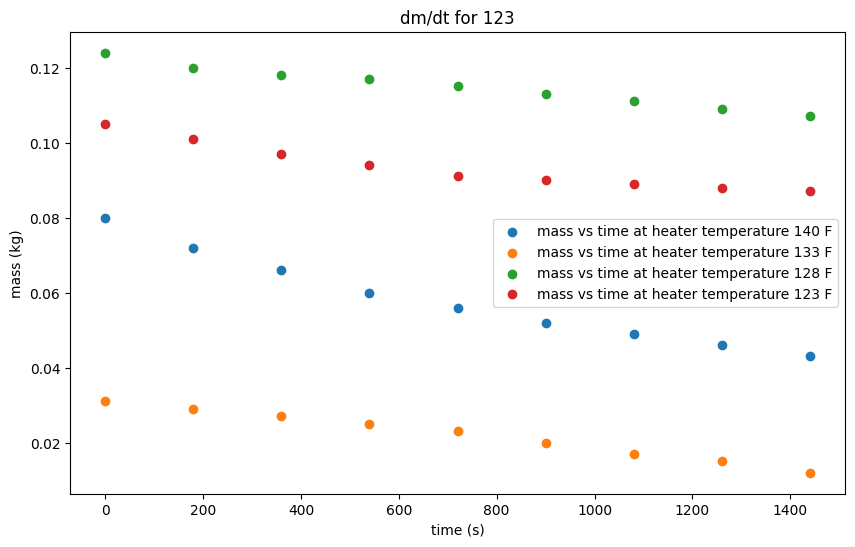

In [973]:
plt.figure(figsize=(10,6))

for temp in df_mass["temperature"].unique():    
    plt.scatter(df_mass.query("temperature == @temp")["time_sec"], df_mass.query("temperature == @temp")["mass_kg"], label=f"mass vs time at heater temperature {temp} F")
    plt.title("dm/dt for {}".format(temp))
    plt.xlabel("time (s)")
    plt.ylabel("mass (kg)")
    plt.legend()

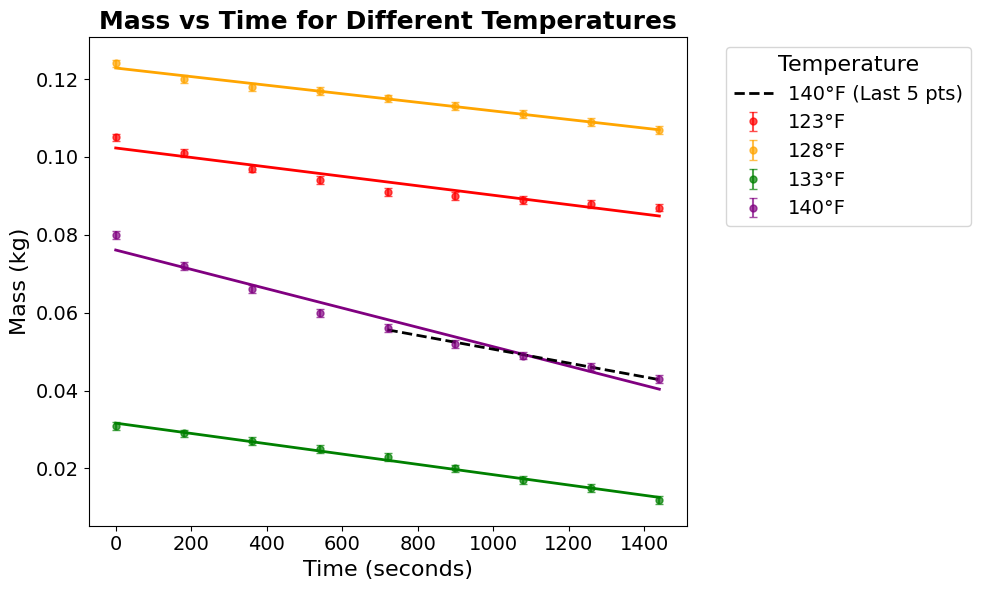

In [974]:
unique_temps = df_mass['temperature'].unique()

fig, ax = plt.subplots(figsize=(10, 6))
colors = np.array(['red', 'orange', 'green', 'purple'])

for i, temp in enumerate(sorted(unique_temps)):
    temp_data = df_mass[df_mass['temperature'] == temp]
    x = temp_data['time_sec']
    y = temp_data['mass_kg']
    
    ax.errorbar(
        x, y,
        yerr=0.001,
        fmt='o',
        label=f'{temp}°F',
        color=colors[i],
        capsize=3,
        alpha=0.7,
        markersize=5
    )

    if len(x) > 1:
        slope, intercept, _, _, _ = linregress(x, y)
        x_line = np.array([min(x), max(x)])
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, color=colors[i], linewidth=2)

temp_140_data = df_mass[df_mass['temperature'] == 140].tail(5)
x_last4 = temp_140_data['time_sec']
y_last4 = temp_140_data['mass_kg']

if len(x_last4) == 5:
    slope_last4, intercept_last4, _, _, _ = linregress(x_last4, y_last4)
    x_fit = np.array([min(x_last4), max(x_last4)])
    y_fit = slope_last4 * x_fit + intercept_last4
    ax.plot(x_fit, y_fit, linestyle='--', color='black', linewidth=2, label='140°F (Last 5 pts)')

ax.set_xlabel('Time (seconds)', fontsize=16)
ax.set_ylabel('Mass (kg)', fontsize=16)
ax.set_title('Mass vs Time for Different Temperatures', fontsize=18, fontweight='bold')
ax.legend(title='Temperature', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title_fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()


Method 1: Take change in mass vs time for each time data point and obtain mass flux for each change in mass observed.

In [975]:
L = 0.555
area_tray = L * 0.200 # m^2
time_elapsed = 3 * 60 # s
df_mass["mass_flux"] = abs(df_mass["delta_mass"]) / (area_tray * time_elapsed)
df_mass

,temperature,time_min,mass,time_sec,mass_kg,delta_mass,mass_flux
0,140,0,80,0,0.080,NaN,NaN
1,140,3,72,180,0.072,-0.008,0.00040
2,140,6,66,360,0.066,-0.006,0.00030
3,140,9,60,540,0.060,-0.006,0.00030
4,140,12,56,720,0.056,-0.004,0.00020
5,140,15,52,900,0.052,-0.004,0.00020
6,140,18,49,1080,0.049,-0.003,0.00015
7,140,21,46,1260,0.046,-0.003,0.00015
8,140,24,43,1440,0.043,-0.003,0.00015
9,133,0,31,0,0.031,NaN,NaN


Method 1 cont: Here we average the mass flux values for each temperature value to obtain our evaporation rate for each bulk air velocity

In [976]:
avg_mass_flux_by_temp = df_mass.groupby("temperature")["mass_flux"].mean().reset_index()
avg_mass_flux_by_temp.rename(columns={"mass_flux": "avg_mass_flux"}, inplace=True)
print(avg_mass_flux_by_temp)

   temperature  avg_mass_flux
0          123       0.000113
1          128       0.000106
2          133       0.000119
3          140       0.000231


Method 2: Now we are going to take a linear fit of mass vs. time to determine evaporation rate, then divide by tray area to obtain mass flux.

Note: We omit the first 4 data points of 140ºF and the first 2 datapoints of 123ºF to account for the skew in our data from not letting the system reach steady-state.

In [977]:
fit_results = []

for temp, group in df_mass.groupby("temperature"):
    group = group.sort_values("time_sec")
    if temp == 140:
        group = group.loc[~group.index.isin([0, 1, 2, 3])]
    if temp == 123:
        group = group.loc[~group.index.isin([27, 28])]
    group = group.dropna(subset=["mass_kg", "time_sec"])
    slope, intercept, r_value, p_value, std_err = linregress(group["time_sec"], group["mass_kg"])
    fit_results.append({
        "temperature": temp,
        "slope": slope,
        "intercept": intercept,
        "r_value": r_value,
        "p_value": p_value,
        "std_err": std_err
    })

fit_df = pd.DataFrame(fit_results)
print(fit_df)

   temperature     slope  intercept   r_value       p_value       std_err
0          123 -0.000009   0.098714 -0.961074  5.622421e-04  1.122392e-06
1          128 -0.000011   0.122822 -0.993970  5.572503e-08  4.594221e-07
2          133 -0.000013   0.031644 -0.996974  5.005478e-09  3.902303e-07
3          140 -0.000018   0.068400 -0.998053  1.031328e-04  6.415003e-07


In [978]:
fit_df["mass_flux"] = abs(fit_df["slope"]) / area_tray
print(fit_df[["temperature", "slope", "mass_flux"]])

   temperature     slope  mass_flux
0          123 -0.000009   0.000079
1          128 -0.000011   0.000099
2          133 -0.000013   0.000119
3          140 -0.000018   0.000160


Method 2 cont: Replacing the mass_flux column in df_mass with the new values from fit_df

In [979]:
mass_flux_map = fit_df.set_index("temperature")["mass_flux"].to_dict()
df_mass["mass_flux"] = df_mass["temperature"].map(mass_flux_map)

df_mass

,temperature,time_min,mass,time_sec,mass_kg,delta_mass,mass_flux
0,140,0,80,0,0.080,NaN,0.000160
1,140,3,72,180,0.072,-0.008,0.000160
2,140,6,66,360,0.066,-0.006,0.000160
3,140,9,60,540,0.060,-0.006,0.000160
4,140,12,56,720,0.056,-0.004,0.000160
5,140,15,52,900,0.052,-0.004,0.000160
6,140,18,49,1080,0.049,-0.003,0.000160
7,140,21,46,1260,0.046,-0.003,0.000160
8,140,24,43,1440,0.043,-0.003,0.000160
9,133,0,31,0,0.031,NaN,0.000119


## Analysis Question 2
Use Eqs. (5) and (6) and appropriate fluid properties to calculate an average for the concentration and the temperature gradients at the evaporating surface normalized along the length of the entire plate (ignoring at this point that the gradients are functions of position along the length of the pan).

$$
N_{A0} \Delta H_{vap} = k_{air} (\frac{dT}{dz})_0 \ \text{(5)}
$$

Using equation 5 for solving temperature gradient

NOTE: Update k to be k_air based on temperature of film

In [980]:
delta_H_vap = 2450 * 1000 # J / kg (I also put the *1000 here because we need in kg)
k_air = 0.02624 # J/m·s·K
k_water = 0.6 # J/m·s·K

combined_df = pd.merge(
    df_mass,
    fit_df[["temperature", "mass_flux"]],
    on="temperature",
    how="left",
    suffixes=("", "_fit") # this changes "mass_flux" in df_mass to "mass_flux_fit" in the combined_df
)

df_mass["dT_dz_0"] = (combined_df["mass_flux_fit"] * delta_H_vap) / k_air # K / m

df_mass

,temperature,time_min,mass,time_sec,mass_kg,delta_mass,mass_flux,dT_dz_0
0,140,0,80,0,0.080,NaN,0.000160,14953.978369
1,140,3,72,180,0.072,-0.008,0.000160,14953.978369
2,140,6,66,360,0.066,-0.006,0.000160,14953.978369
3,140,9,60,540,0.060,-0.006,0.000160,14953.978369
4,140,12,56,720,0.056,-0.004,0.000160,14953.978369
5,140,15,52,900,0.052,-0.004,0.000160,14953.978369
6,140,18,49,1080,0.049,-0.003,0.000160,14953.978369
7,140,21,46,1260,0.046,-0.003,0.000160,14953.978369
8,140,24,43,1440,0.043,-0.003,0.000160,14953.978369
9,133,0,31,0,0.031,NaN,0.000119,11137.598472


We can use equation 3 to substitute into the LHS of equation 6

$$
N_A = \frac{-cD_{AB}}{1-x_A} \nabla x_A \ \text{(3)}
$$

$$
-\frac{cD_{AB}}{1-x_{A0}} (\frac{dx_A}{dz})_0 = \frac{k_{air}}{\Delta H_{vap}} (\frac{dT}{dz})_0 \ \text{(6)}
$$

At the interface we have

$$
N_A = \frac{D_{AB}}{1-x_{A0}} \nabla c_A
$$

Then, we can solve for concentration gradient as

$$
\nabla c_A = \frac{N_A}{\frac{D_{AB}}{1-x_{A0}}}
$$

NOTE: get diffusivity from table based on film temp and pressure. using equation 3, move c into grad x_a and solve for x_a0 using antoine's equation

We will start by computing x_A0 with Antoine's equation below using thermocouple measurements at the water surface

$$
x_{A0} = \frac{\text{exp}(18.3036 - \frac{3816.44}{T - 46.13})}{760 P}
$$

In [981]:
def to_C(farenheit):
    return (farenheit - 32) * (5/9)

df_tc["TC1_C"] = df_tc["TC1"].apply(to_C)
df_tc["TC2_C"] = df_tc["TC2"].apply(to_C)
df_tc["TC3_C"] = df_tc["TC3"].apply(to_C)
df_tc["TC4_C"] = df_tc["TC4"].apply(to_C)

In [982]:
def to_K(celsius):
    return celsius + 273.15

df_tc["TC1_K"] = df_tc["TC1_C"].apply(to_K)
df_tc["TC2_K"] = df_tc["TC2_C"].apply(to_K)
df_tc["TC3_K"] = df_tc["TC3_C"].apply(to_K)
df_tc["TC4_K"] = df_tc["TC4_C"].apply(to_K)

Using diffusivity of water (A) in air (B) at 298 Kelvin and assuming atmospheric pressure (1 atm = 101325 Pa)

**NOTE: potentially update diffusivity to not be for 298 K**

**TODO: check pressure units**

In [983]:
P = 101325 # Pa
P_atm = 1 # atm
D_AB = 2.634 / P # m^2 / s

We take an average of water measuring thermocouples (TC2 and TC4) to get the surface temperature of water

In [984]:
df_tc["surf_temp_avg_K"] = (df_tc["TC2_K"] + df_tc["TC4_K"]) / 2

In [985]:
df_tc["x_A0"] = np.exp(18.3036 - (3816.44 / (df_tc["surf_temp_avg_K"] - 46.13))) / (760 * P_atm)

In [986]:
df_tc

,heater_temp,TC1,TC2,TC3,TC4,TC1_C,TC2_C,TC3_C,TC4_C,TC1_K,TC2_K,TC3_K,TC4_K,surf_temp_avg_K,x_A0
0,140,122.1,67.5,90.3,76.1,50.055556,19.722222,32.388889,24.500000,323.205556,292.872222,305.538889,297.650000,295.261111,0.026024
1,133,118.5,71.9,89.4,78.9,48.055556,22.166667,31.888889,26.055556,321.205556,295.316667,305.038889,299.205556,297.261111,0.029401
2,128,115.0,72.4,88.4,76.4,46.111111,22.444444,31.333333,24.666667,319.261111,295.594444,304.483333,297.816667,296.705556,0.028427
3,123,110.1,71.8,84.3,73.8,43.388889,22.111111,29.055556,23.222222,316.538889,295.261111,302.205556,296.372222,295.816667,0.026927


Adding x_A0 to df_mass using merge on temperature

In [987]:
df_mass = df_mass.merge(df_tc[["heater_temp", "x_A0"]], left_on="temperature", right_on="heater_temp", how="left")
df_mass.drop(columns=["heater_temp"], inplace=True)

$$
\nabla c_A = \frac{N_A}{\frac{D_{AB}}{1-x_{A0}}}
$$

In [988]:
water_molar_mass = (18.01528 / 1000) # kg / mol
df_mass["mole_flux"] = df_mass["mass_flux"] * (1 / water_molar_mass)
df_mass

,temperature,time_min,mass,time_sec,mass_kg,delta_mass,mass_flux,dT_dz_0,x_A0,mole_flux
0,140,0,80,0,0.080,NaN,0.000160,14953.978369,0.026024,0.008890
1,140,3,72,180,0.072,-0.008,0.000160,14953.978369,0.026024,0.008890
2,140,6,66,360,0.066,-0.006,0.000160,14953.978369,0.026024,0.008890
3,140,9,60,540,0.060,-0.006,0.000160,14953.978369,0.026024,0.008890
4,140,12,56,720,0.056,-0.004,0.000160,14953.978369,0.026024,0.008890
5,140,15,52,900,0.052,-0.004,0.000160,14953.978369,0.026024,0.008890
6,140,18,49,1080,0.049,-0.003,0.000160,14953.978369,0.026024,0.008890
7,140,21,46,1260,0.046,-0.003,0.000160,14953.978369,0.026024,0.008890
8,140,24,43,1440,0.043,-0.003,0.000160,14953.978369,0.026024,0.008890
9,133,0,31,0,0.031,NaN,0.000119,11137.598472,0.029401,0.006621


In [989]:
air_molar_mass = 0.029 # kg / mol
R = 8.314 # J / mol·K

df_mass["w_A0"] = (
    df_mass["x_A0"] * water_molar_mass
) / (
    df_mass["x_A0"] * water_molar_mass + (1 - df_mass["x_A0"]) * air_molar_mass
)

df_mass = df_mass.merge(
    df_tc[["heater_temp", "surf_temp_avg_K"]],
    left_on="temperature",
    right_on="heater_temp",
    how="left"
).drop(columns=["heater_temp"])

df_mass["c_air"] = P / (R * df_mass["surf_temp_avg_K"])  # mol/m³

# with the c_air
# df_mass["conc_gradient_mass"] = (df_mass["mass_flux"] * (1 - df_mass["w_A0"])) / (df_mass["c_air"] * D_AB) # kg_H2O / m
# df_mass["conc_gradient_mol"] = (df_mass["mole_flux"] * (1 - df_mass["x_A0"])) /(df_mass["c_air"] * D_AB) # mol_H2O / m

df_mass["conc_gradient_mass"] = (df_mass["mass_flux"] * (1 - df_mass["w_A0"])) / (D_AB) # kg_H2O / m
df_mass["conc_gradient_mol"] = (df_mass["mole_flux"] * (1 - df_mass["x_A0"])) /(D_AB) # mol_H2O / m

## Analysis Question 3
Using the gradients calculated above, estimate the average thicknesses of the concentration and thermal boundary layers by assuming that both the concentration and the temperature profiles are linear starting at the interface value and ending at the bulk flow values at the top boundary. Which boundary-layer thickness is larger? Is the relationship between the two boundary layer thicknesses as expected? How do the average boundary layer thicknesses scale with velocity? Is this as expected? Why or why not?

If we assume that the concentration and temperature profiles are linear from the interface value to the bulk flow value, then we will use our values from `dT_dz_0` and `conc_gradient_mass` and take an average value of the columns for boundary-layer thicknesses.

Another assumption we will make is that the interface gas can be treated as an ideal gas 

**TODO: update the bulk temperature with accurate value**

**TODO: justify why the air can be treated as an ideal gas**

In [990]:
df_tc["air_temp_avg_K"] = (df_tc["TC1_K"] + df_tc["TC3_K"]) / 2

In [991]:
R = 8.314 # J / mol * K
P_kpa = P / 1000
T_air = df_tc["air_temp_avg_K"].mean() # K

c_air = P / (R * T_air)

In [992]:
df_mass["c_A0"] = df_mass["x_A0"] * df_mass["c_air"]

For thermal boundary layer, we can use:
$$
\delta_{t} = \frac{T_{bulk} - T_0}{(\frac{dT}{dz})_{z=0}}
$$

and for concentration boundary layer, we use:

$$
\delta_{c} = \frac{c_A - c_{A,0}}{(\frac{dc_A}{dz})_{z=0}}
$$

In [993]:
# delta_T = T_air - df_tc["surf_temp_avg_K"].mean()
# delta_C = c_air - df_mass["c_A0"].mean()

We use the blow formulation to get x_A_inf

$$ 
x_{A, \infin } = (\frac{\text{RH}}{100}) \times \frac{\text{P}_{sat}}{P}
$$

which we need P_sat for:

$$ 
\text{log}_{10} (P_{sat, mmHg}) = A - \frac{B}{C+T}
$$

such that 

$$
A = 8.07131
\newline
B = 1730.63
\newline
C = 233.426
$$

In [994]:
df_mass["conc_BL_thickness"] = np.nan
df_mass["temp_BL_thickness"] = np.nan

for temp, group in df_mass.groupby("temperature"):
    T_surf = df_tc[df_tc["heater_temp"] == temp]["surf_temp_avg_K"].values[0]
    c_A0 = group["c_A0"].mean()
    
    T_air_C = df_anemometer[df_anemometer["heater_temp"] == temp]["temperature_ane"].values[0]
    RH = df_anemometer[df_anemometer["heater_temp"] == temp]["relative_humidity"].values[0]
    T_air_K = T_air_C + 273.15

    A, B, C = 8.07131, 1730.63, 233.426
    P_sat_mmHg = 10**(A - (B / (T_air_C + C)))
    P_sat_Pa = P_sat_mmHg * 133.322368
    P_H2O = RH / 100 * (P_sat_Pa / P)

    x_A_inf = P_H2O / P
    c_total = P / (R * T_air_K)
    c_A_inf = x_A_inf * c_total

    delta_T = T_air_K - T_surf
    delta_C = c_A0 - c_A_inf

    conc_BL = delta_C / group["conc_gradient_mol"]
    temp_BL = delta_T / group["dT_dz_0"]

    df_mass.loc[group.index, "conc_BL_thickness"] = conc_BL
    df_mass.loc[group.index, "temp_BL_thickness"] = temp_BL


In [1]:
df_anemometer

NameError: name 'df_anemometer' is not defined

Now we can check scaling of boundary layers with velocity

In [996]:
df_anemometer

,heater_temp,distance,relative_humidity,air_velocity,temperature_ane,air_velocity_ms
0,140,4,25.3,420.0,84.2,2.13360
1,140,8,25.3,NaN,84.2,NaN
2,140,12,25.3,322.0,84.2,1.63576
3,140,16,25.3,NaN,84.2,NaN
4,140,20,25.3,410.0,84.2,2.08280
5,133,4,27.7,250.0,81.2,1.27000
6,133,8,27.7,NaN,81.2,NaN
7,133,12,27.7,190.0,81.2,0.96520
8,133,16,27.7,NaN,81.2,NaN
9,133,20,27.7,334.0,81.2,1.69672


We don't have any unique measurements at horizontal distances 8 or 16 so we will drop those columns so its easier to manage the `NaN` items

In [997]:
df_anemometer = df_anemometer[~df_anemometer["distance"].isin([8, 16])].reset_index(drop=True)

The lab manual asks for an average of air velocities across horizontal distances so we will do just that

In [998]:
avg_air_velocities = df_anemometer.groupby("heater_temp")["air_velocity_ms"].mean().rename("avg_air_velocity")
df_anemometer = df_anemometer.merge(avg_air_velocities, on="heater_temp", how="left")

In [999]:
velocity_map = df_anemometer.drop_duplicates("heater_temp")[["heater_temp", "avg_air_velocity"]]
velocity_map = velocity_map.rename(columns={"heater_temp": "temperature"})

df_mass = df_mass.merge(velocity_map, on="temperature", how="left")

In [1000]:
avg_velocities = {}

for temp in df_mass["temperature"].unique():
    avg_velocities[temp] = df_mass.query(f"temperature == {temp}")["avg_air_velocity"].iloc[0]

In [1001]:
df_mass

,temperature,time_min,mass,time_sec,mass_kg,delta_mass,mass_flux,dT_dz_0,x_A0,mole_flux,w_A0,surf_temp_avg_K,c_air,conc_gradient_mass,conc_gradient_mol,c_A0,conc_BL_thickness,temp_BL_thickness,avg_air_velocity
0,140,0,80,0,0.080,NaN,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
1,140,3,72,180,0.072,-0.008,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
2,140,6,66,360,0.066,-0.006,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
3,140,9,60,540,0.060,-0.006,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
4,140,12,56,720,0.056,-0.004,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
5,140,15,52,900,0.052,-0.004,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
6,140,18,49,1080,0.049,-0.003,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
7,140,21,46,1260,0.046,-0.003,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
8,140,24,43,1440,0.043,-0.003,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
9,133,0,31,0,0.031,NaN,0.000119,11137.598472,0.029401,0.006621,0.018470,297.261111,40.998550,4.503951,247.223009,1.205406,0.004876,0.005126,1.31064


Finally, we can check the scaling of the thicknesses with air velocity

In [1002]:
thicknesses = {
    "heater_temp": [140, 133, 128, 123],
    "delta_c": [0.003225, 0.004876, 0.005670, 0.006788],
    "delta_t": [0.004152, 0.005126, 0.005809, 0.007045],
}
df_thickness = pd.DataFrame(thicknesses)

df_thickness["avg_velocity"] = df_thickness["heater_temp"].map(avg_velocities)

df_thickness["log_velocity"] = np.log(df_thickness["avg_velocity"])
df_thickness["log_delta_c"] = np.log(df_thickness["delta_c"])
df_thickness["log_delta_t"] = np.log(df_thickness["delta_t"])

slope_c, intercept_c = np.polyfit(df_thickness["log_velocity"], df_thickness["log_delta_c"], 1)
slope_t, intercept_t = np.polyfit(df_thickness["log_velocity"], df_thickness["log_delta_t"], 1)

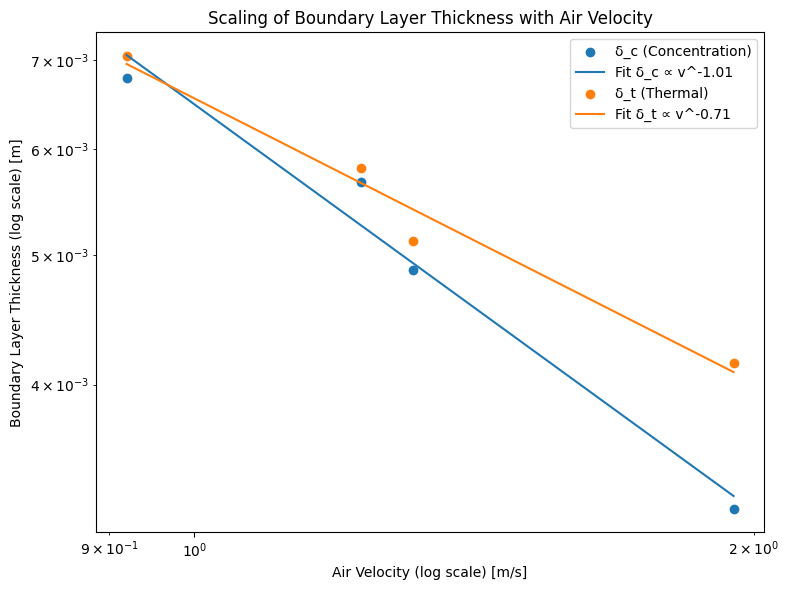

In [1003]:
plt.figure(figsize=(8, 6))
plt.scatter(df_thickness["avg_velocity"], df_thickness["delta_c"], label="δ_c (Concentration)", marker="o")
plt.plot(df_thickness["avg_velocity"], np.exp(intercept_c) * df_thickness["avg_velocity"]**slope_c,
         label=f"Fit δ_c ∝ v^{slope_c:.2f}")

plt.scatter(df_thickness["avg_velocity"], df_thickness["delta_t"], label="δ_t (Thermal)")
plt.plot(df_thickness["avg_velocity"], np.exp(intercept_t) * df_thickness["avg_velocity"]**slope_t,
         label=f"Fit δ_t ∝ v^{slope_t:.2f}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Air Velocity (log scale) [m/s]")
plt.ylabel("Boundary Layer Thickness (log scale) [m]")
plt.title("Scaling of Boundary Layer Thickness with Air Velocity")
plt.legend()
plt.tight_layout()
plt.show()

In [1004]:
df_mass

,temperature,time_min,mass,time_sec,mass_kg,delta_mass,mass_flux,dT_dz_0,x_A0,mole_flux,w_A0,surf_temp_avg_K,c_air,conc_gradient_mass,conc_gradient_mol,c_A0,conc_BL_thickness,temp_BL_thickness,avg_air_velocity
0,140,0,80,0,0.080,NaN,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
1,140,3,72,180,0.072,-0.008,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
2,140,6,66,360,0.066,-0.006,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
3,140,9,60,540,0.060,-0.006,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
4,140,12,56,720,0.056,-0.004,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
5,140,15,52,900,0.052,-0.004,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
6,140,18,49,1080,0.049,-0.003,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
7,140,21,46,1260,0.046,-0.003,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
8,140,24,43,1440,0.043,-0.003,0.000160,14953.978369,0.026024,0.008890,0.016328,295.261111,41.276260,6.060462,333.090613,1.074190,0.003225,0.004152,1.95072
9,133,0,31,0,0.031,NaN,0.000119,11137.598472,0.029401,0.006621,0.018470,297.261111,40.998550,4.503951,247.223009,1.205406,0.004876,0.005126,1.31064


## Analysis Question 4
How does km, the average mass transfer coefficient along the length of the plate, vary with the velocity of the gas stream?  Is the scaling of km with velocity what you would expect?  Why or why not?  Is this scaling consistent with the laminar/turbulent nature of the air flow in the experiment, as calculated from the Reynolds number? That is to say, the Reynolds number controls the laminar/turbulent nature of flow, but this nature of the flow affects the scaling of km with velocity. Is there self-consistency between this scaling and the Reynolds number?

Our first step will be determining if this flow is laminar or turbulent

$$
Re = \frac{\rho v L}{\mu}
$$

**TODO: check density, kinematic viscosity**

In [1005]:
rho = 1.2 # kg / m^3 
mu_0 = 1.716e-5     # Pa·s
T_0 = 273.15        # K
S_mu = 111          # K

df_anemometer["T_air_K"] = df_anemometer["temperature_ane"] + 273.15
df_anemometer["mu_air"] = mu_0 * (
    (df_anemometer["T_air_K"] / T_0) ** 1.5
) * ((T_0 + S_mu) / (df_anemometer["T_air_K"] + S_mu))


df_anemometer["Re"] = (rho * df_anemometer["avg_air_velocity"] * L * 0.00508) / df_anemometer["mu_air"]

In [1006]:
def classify_flow(Re):
    if Re < (2100):
        return "Lam"
    elif Re > (2100):
        return "Turb"
    else:
        return "Transitional"

In [1007]:
df_anemometer["flow_regime"] = df_anemometer["Re"].apply(classify_flow)

In [1008]:
df_anemometer

,heater_temp,distance,relative_humidity,air_velocity,temperature_ane,air_velocity_ms,avg_air_velocity,T_air_K,mu_air,Re,flow_regime
0,140,4,25.3,420.0,84.2,2.13360,1.95072,357.35,0.000021,313.362057,Lam
1,140,12,25.3,322.0,84.2,1.63576,1.95072,357.35,0.000021,313.362057,Lam
2,140,20,25.3,410.0,84.2,2.08280,1.95072,357.35,0.000021,313.362057,Lam
3,133,4,27.7,250.0,81.2,1.27000,1.31064,354.35,0.000021,211.853727,Lam
4,133,12,27.7,190.0,81.2,0.96520,1.31064,354.35,0.000021,211.853727,Lam
5,133,20,27.7,334.0,81.2,1.69672,1.31064,354.35,0.000021,211.853727,Lam
6,128,4,30.4,204.0,77.4,1.03632,1.22936,350.55,0.000021,200.306252,Lam
7,128,12,30.4,227.0,77.4,1.15316,1.22936,350.55,0.000021,200.306252,Lam
8,128,20,30.4,295.0,77.4,1.49860,1.22936,350.55,0.000021,200.306252,Lam
9,123,4,33.4,155.0,74.4,0.78740,0.91948,347.55,0.000021,150.773381,Lam


It seems that the flow regime is laminar for all temperatures, this informs what the expected scaling is between k_m and air velocity based on a Reynold's number expression

We can first compute the mass transfer coefficient value as:

$$ 
c_A = c_{air} (x_{A0} - x_{Ae}) \approx cx_{A0} 

\ \text{assuming} \

x_{Ae} \approx 0
$$

so, our expression for mass transfer coeff is given by a few potential expressions

$$ 
\text{Film Theory}
\newline
k_m = \frac{N_A}{cx_{A0}}
$$

$$ 
\text{Penetration Theory}
\newline
k_m = \sqrt{\frac{D_{AB}v_\infin}{\pi\delta}}
$$

$$ 
\text{Boundary Layer Theory}
\newline
k_m = 0.664 \frac{D_{AB}}{L} (\text{Re})^{\frac{1}{2}} (\text{Sc})^{\frac{1}{3}}
$$

In [1009]:
temp_to_velocity = {140: 1.95072, 133: 1.31064, 128: 1.22936, 123: 0.91948}
temp_to_re = {140: 313.362057, 133: 211.853727, 128: 200.306252, 123: 150.773381}
df_mass["velocity"] = df_mass["temperature"].map(temp_to_velocity)
df_mass["Re"] = df_mass["temperature"].map(temp_to_re)

In [1010]:
kin_viscosity = df_anemometer["mu_air"].iloc[0] / rho
schmidt = kin_viscosity / D_AB

In [1011]:
df_mass["k_m_film"] = df_mass["mass_flux"] / (df_mass["conc_BL_thickness"]) 
df_mass["k_m_penetration"] = np.sqrt((D_AB * df_mass["avg_air_velocity"]) / (np.pi * df_mass["conc_BL_thickness"]))
df_mass["k_m_BL"] = 0.664 * (D_AB / L) * (df_mass["Re"] ** (1/2)) * (schmidt) ** (1/3)

In [1012]:
df_mass[["Re"]]

,Re
0,313.362057
1,313.362057
2,313.362057
3,313.362057
4,313.362057
5,313.362057
6,313.362057
7,313.362057
8,313.362057
9,211.853727


In [1013]:
df_anemometer

,heater_temp,distance,relative_humidity,air_velocity,temperature_ane,air_velocity_ms,avg_air_velocity,T_air_K,mu_air,Re,flow_regime
0,140,4,25.3,420.0,84.2,2.13360,1.95072,357.35,0.000021,313.362057,Lam
1,140,12,25.3,322.0,84.2,1.63576,1.95072,357.35,0.000021,313.362057,Lam
2,140,20,25.3,410.0,84.2,2.08280,1.95072,357.35,0.000021,313.362057,Lam
3,133,4,27.7,250.0,81.2,1.27000,1.31064,354.35,0.000021,211.853727,Lam
4,133,12,27.7,190.0,81.2,0.96520,1.31064,354.35,0.000021,211.853727,Lam
5,133,20,27.7,334.0,81.2,1.69672,1.31064,354.35,0.000021,211.853727,Lam
6,128,4,30.4,204.0,77.4,1.03632,1.22936,350.55,0.000021,200.306252,Lam
7,128,12,30.4,227.0,77.4,1.15316,1.22936,350.55,0.000021,200.306252,Lam
8,128,20,30.4,295.0,77.4,1.49860,1.22936,350.55,0.000021,200.306252,Lam
9,123,4,33.4,155.0,74.4,0.78740,0.91948,347.55,0.000021,150.773381,Lam


In [1014]:
temp_to_velocity = {140: 1.95072, 133: 1.31064, 128: 1.22936, 123: 0.91948}
temp_to_re = {140: 313.362057, 133: 211.853727, 128: 200.306252, 123: 150.773381}
df_mass["velocity"] = df_mass["temperature"].map(temp_to_velocity)
df_mass["Re"] = df_mass["temperature"].map(temp_to_velocity)

In [1015]:
df_mass_clean = df_mass.dropna(subset=["k_m_film"])

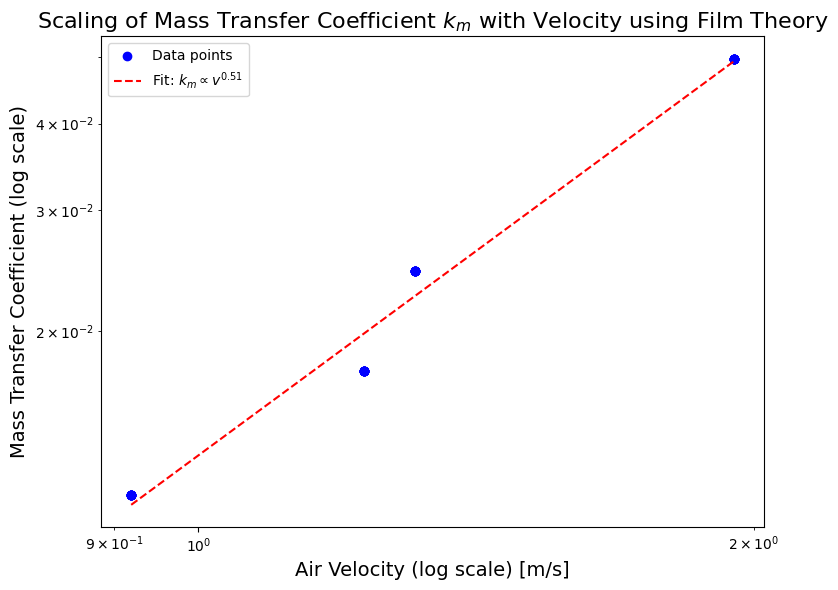

In [1025]:
plt.figure(figsize=(8,6))
plt.scatter(df_mass_clean["velocity"], df_mass_clean["k_m_film"], color="blue", label="Data points")

log_v = np.log(df_mass_clean["velocity"])
log_km = np.log(df_mass_clean["k_m_film"])
slope, intercept = np.polyfit(log_v, log_km, 1)
v_sorted = np.sort(df_mass_clean["velocity"].unique())
plt.plot(v_sorted, np.exp(intercept) * v_sorted**slope, color="red", linestyle="--",
         label=f"Fit: $k_m \\propto v^{{{1/slope:.2f}}}$")

plt.xscale("log")
plt.yscale("log")
plt.xlabel('Air Velocity (log scale) [m/s]', fontsize=14)
plt.ylabel('Mass Transfer Coefficient (log scale)', fontsize=14)
plt.title('Scaling of Mass Transfer Coefficient $k_m$ with Velocity using Film Theory', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

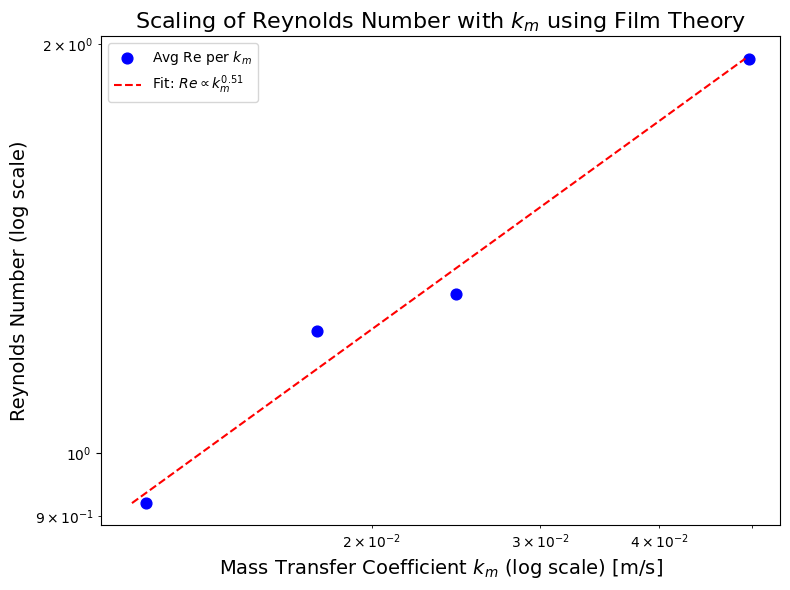

In [1022]:
plt.figure(figsize=(8, 6))
grouped = df_mass.groupby("Re").agg(k_m_film=("k_m_film", "mean")).reset_index()
grouped

log_Re = np.log(grouped["Re"])
log_km = np.log(grouped["k_m_film"])
slope, intercept = linregress(log_Re, log_km)[:2]

Re_fit = np.linspace(grouped["Re"].min(), grouped["Re"].max(), 100)
km_fit = np.exp(intercept) * Re_fit**slope

plt.scatter(grouped["k_m_film"], grouped["Re"], color='blue', s=60, label='Avg Re per $k_m$')
plt.plot(km_fit, Re_fit, color='red', linestyle='--', label=f'Fit: $Re \\propto k_m^{{{1/slope:.2f}}}$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mass Transfer Coefficient $k_m$ (log scale) [m/s]', fontsize=14)
plt.ylabel('Reynolds Number (log scale)', fontsize=14)
plt.title('Scaling of Reynolds Number with $k_m$ using Film Theory', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


        Re    k_m_BL
0  0.91948  0.000335
1  1.22936  0.000386
2  1.31064  0.000397
3  1.95072  0.000483


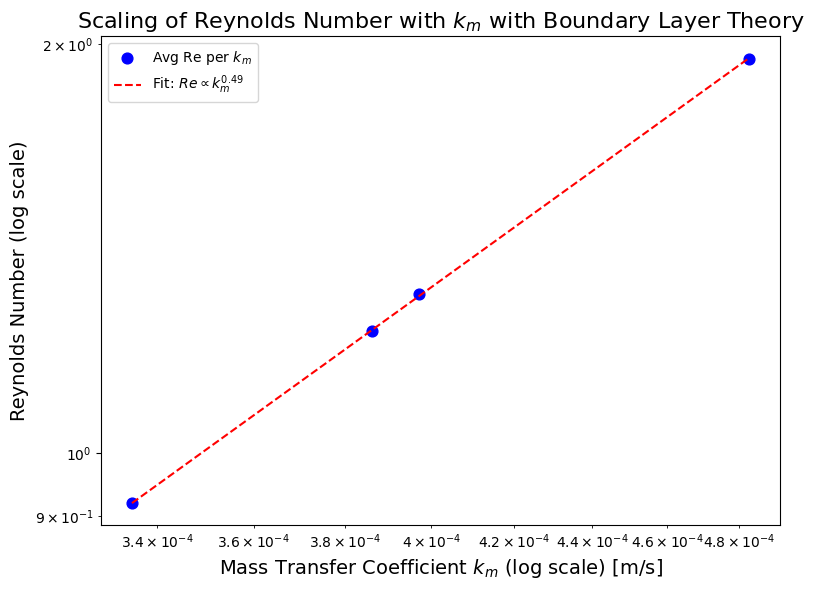

In [1023]:
plt.figure(figsize=(8, 6))
grouped = df_mass.groupby("Re").agg(k_m_BL=("k_m_BL", "mean")).reset_index()
print(grouped)

log_Re = np.log(grouped["Re"])
log_km = np.log(grouped["k_m_BL"])
slope, intercept = linregress(log_Re, log_km)[:2]

Re_fit = np.linspace(grouped["Re"].min(), grouped["Re"].max(), 100)
km_fit = np.exp(intercept) * Re_fit**slope

plt.scatter(grouped["k_m_BL"], grouped["Re"], color='blue', s=60, label='Avg Re per $k_m$')
plt.plot(km_fit, Re_fit, color='red', linestyle='--', label=f'Fit: $Re \\propto k_m^{{{slope:.2f}}}$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mass Transfer Coefficient $k_m$ (log scale) [m/s]', fontsize=14)
plt.ylabel('Reynolds Number (log scale)', fontsize=14)
plt.title('Scaling of Reynolds Number with $k_m$ with Boundary Layer Theory', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

In [1019]:
df_mass

,temperature,time_min,mass,time_sec,mass_kg,delta_mass,mass_flux,dT_dz_0,x_A0,mole_flux,...,conc_gradient_mol,c_A0,conc_BL_thickness,temp_BL_thickness,avg_air_velocity,velocity,Re,k_m_film,k_m_penetration,k_m_BL
0,140,0,80,0,0.080,NaN,0.000160,14953.978369,0.026024,0.008890,...,333.090613,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483
1,140,3,72,180,0.072,-0.008,0.000160,14953.978369,0.026024,0.008890,...,333.090613,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483
2,140,6,66,360,0.066,-0.006,0.000160,14953.978369,0.026024,0.008890,...,333.090613,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483
3,140,9,60,540,0.060,-0.006,0.000160,14953.978369,0.026024,0.008890,...,333.090613,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483
4,140,12,56,720,0.056,-0.004,0.000160,14953.978369,0.026024,0.008890,...,333.090613,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483
5,140,15,52,900,0.052,-0.004,0.000160,14953.978369,0.026024,0.008890,...,333.090613,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483
6,140,18,49,1080,0.049,-0.003,0.000160,14953.978369,0.026024,0.008890,...,333.090613,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483
7,140,21,46,1260,0.046,-0.003,0.000160,14953.978369,0.026024,0.008890,...,333.090613,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483
8,140,24,43,1440,0.043,-0.003,0.000160,14953.978369,0.026024,0.008890,...,333.090613,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483
9,133,0,31,0,0.031,NaN,0.000119,11137.598472,0.029401,0.006621,...,247.223009,1.205406,0.004876,0.005126,1.31064,1.31064,1.31064,0.024466,0.047163,0.000397


     k_m_BL  velocity
0  0.000335   0.91948
1  0.000386   1.22936
2  0.000397   1.31064
3  0.000483   1.95072


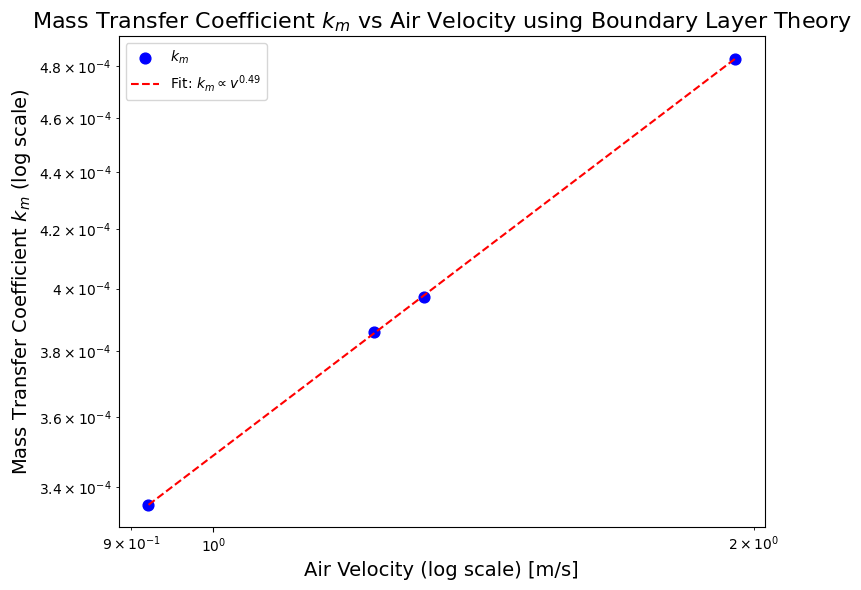

In [1024]:
plt.figure(figsize=(8, 6))
grouped = df_mass.groupby("k_m_BL").agg(velocity=("velocity", "mean")).reset_index()
print(grouped)

log_Re = np.log(grouped["k_m_BL"])
log_v = np.log(grouped["velocity"])
slope, intercept = linregress(log_Re, log_v)[:2]

Re_fit = np.linspace(grouped["k_m_BL"].min(), grouped["k_m_BL"].max(), 100)
km_fit = np.exp(intercept) * Re_fit**slope

plt.scatter(grouped["velocity"], grouped["k_m_BL"], color='blue', s=60, label='$k_m$')
plt.plot(km_fit, Re_fit, color='red', linestyle='--', label=f'Fit: $k_m \\propto v^{{{1/ slope:.2f}}}$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Air Velocity (log scale) [m/s]', fontsize=14)
plt.ylabel('Mass Transfer Coefficient $k_m$ (log scale)', fontsize=14)
plt.title('Mass Transfer Coefficient $k_m$ vs Air Velocity using Boundary Layer Theory', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


## Question 5
Compare the spatially-averaged values of km from the previous part to the values based on the film theory, i.e., km = D/c. Compare your results and explain the cause of differences.

In [1034]:
df_mass["k_m_non_avg"] = D_AB / (c_air - c_A0)

In [1035]:
df_mass

,temperature,time_min,mass,time_sec,mass_kg,delta_mass,mass_flux,dT_dz_0,x_A0,mole_flux,...,c_A0,conc_BL_thickness,temp_BL_thickness,avg_air_velocity,velocity,Re,k_m_film,k_m_penetration,k_m_BL,k_m_non_avg
0,140,0,80,0,0.080,NaN,0.000160,14953.978369,0.026024,0.008890,...,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483,6.847338e-07
1,140,3,72,180,0.072,-0.008,0.000160,14953.978369,0.026024,0.008890,...,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483,6.847338e-07
2,140,6,66,360,0.066,-0.006,0.000160,14953.978369,0.026024,0.008890,...,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483,6.847338e-07
3,140,9,60,540,0.060,-0.006,0.000160,14953.978369,0.026024,0.008890,...,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483,6.847338e-07
4,140,12,56,720,0.056,-0.004,0.000160,14953.978369,0.026024,0.008890,...,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483,6.847338e-07
5,140,15,52,900,0.052,-0.004,0.000160,14953.978369,0.026024,0.008890,...,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483,6.847338e-07
6,140,18,49,1080,0.049,-0.003,0.000160,14953.978369,0.026024,0.008890,...,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483,6.847338e-07
7,140,21,46,1260,0.046,-0.003,0.000160,14953.978369,0.026024,0.008890,...,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483,6.847338e-07
8,140,24,43,1440,0.043,-0.003,0.000160,14953.978369,0.026024,0.008890,...,1.074190,0.003225,0.004152,1.95072,1.95072,1.95072,0.049665,0.070749,0.000483,6.847338e-07
9,133,0,31,0,0.031,NaN,0.000119,11137.598472,0.029401,0.006621,...,1.205406,0.004876,0.005126,1.31064,1.31064,1.31064,0.024466,0.047163,0.000397,6.847338e-07
